## Developing a tensorflow based multilinear interpolator

Author: Vicente Paul Guerrero Lule

Date: 24.02.2019

In [1]:
import tensorflow as tf
import numpy as np
import sys, os
import matplotlib.pyplot as plt
%matplotlib inline
import time
import imageio

wk_dir = os.path.abspath(os.path.dirname('__file__'))

In [2]:
file_name = 'images/android.png'
file_path = os.path.join(wk_dir, file_name)

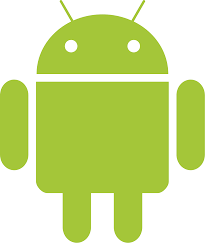

In [3]:
# Original
from IPython.display import Image
Image(file_name)

# A simple 3D example using the same image

(245, 206, 4)
(1, 245, 206, 3, 4)


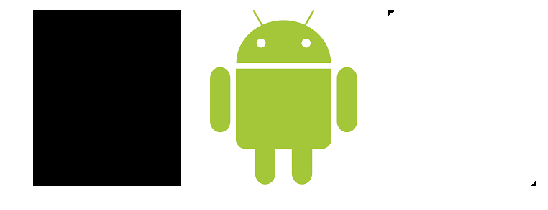

In [4]:
# build a 3d volume based on 3 images
file_name = 'images/android_black.png'
file_path = os.path.join(wk_dir, file_name)
image_black = imageio.imread(file_name).astype(np.float32)
file_name = 'images/android.png'
file_path = os.path.join(wk_dir, file_name)
image_orig = imageio.imread(file_name).astype(np.float32)
file_name = 'images/android_white.png'
file_path = os.path.join(wk_dir, file_name)
image_white = imageio.imread(file_name).astype(np.float32)
print(image_white.shape)

d3_volume = np.zeros((1, 245, 206, 3, 4))
d3_volume[0,:,:,0,:] = image_black
d3_volume[0,:,:,1,:] = image_orig
d3_volume[0,:,:,2,:] = image_white
print(d3_volume.shape)

fig = plt.figure(figsize=(9,10))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1)
    ax.imshow(d3_volume[0,:,:,i,:].astype(np.int32))
    ax.axis('off')  # clear x-axis and y-axis
plt.show()

### For the 3d case

In [5]:
def _resize_by_axis_trilinear(image, dim_1, dim_2, ax):

    resized_list = []

    # unstack the image in 2d cases
    unstack_list = tf.unstack(image, axis = ax)
    for i in unstack_list:
        resized_list.append(tf.image.resize_bilinear(i, [dim_1, dim_2]))
    stack_img = tf.stack(resized_list, axis=ax)

    return stack_img

In [6]:
def resize_trilinear(content, size):
    assert size.shape[0] == 3
    resized = _resize_by_axis_trilinear(content, size[0], size[1], 2)
    resized = _resize_by_axis_trilinear(resized, size[0], size[2], 1)
    return resized

In [7]:
new_size = np.ones((3), dtype=np.int32)
new_size[0] = 100
new_size[1] = 100
new_size[2] = 5

In [8]:
image_content = tf.constant(d3_volume, dtype=tf.int32)
resized = resize_trilinear(image_content, new_size)
images_resized_int = tf.cast(resized, tf.int32)

start = time.time()
with tf.Session() as sess:
    tf_result = sess.run(images_resized_int)
print('Execution time:', time.time() - start)
print(tf_result.shape)

Execution time: 1.4383647441864014
(1, 100, 100, 5, 4)


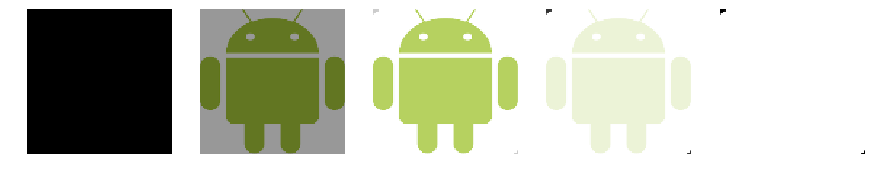

In [9]:
fig = plt.figure(figsize=(15,10))

for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(tf_result[0,:,:,i,:].astype(np.int32))
    ax.axis('off')  # clear x-axis and y-axis
plt.show()

### For the 4d case

In [10]:
def _resize_by_axis_tetralinear(image, dim_1, dim_2, dim_3, ax):

    resized_list = []

    # unstack the image in 3d cases
    unstack_list = tf.unstack(image, axis = ax)
    for i in unstack_list:
        resized_list.append(resize_trilinear(i, np.array([dim_1, dim_2, dim_3])))
    stack_img = tf.stack(resized_list, axis=ax)

    return stack_img

In [11]:
def resize_tetralinear(content, size):
    assert size.shape[0] == 4
    resized = _resize_by_axis_tetralinear(content, size[0], size[1], size[2], 4)
    resized = _resize_by_axis_tetralinear(resized, size[0], size[1], size[3], 3)
    return resized

In [12]:
# create a random dataset
d4_volume = np.random.rand(1, 20, 20, 3, 3, 4)  #20x20x3x3
d4_volume = d4_volume * 255.0
d4_volume = d4_volume.astype(np.int32)
d4_volume.shape

(1, 20, 20, 3, 3, 4)

In [13]:
new_size = np.ones((4), dtype=np.int32)
new_size[0] = 12
new_size[1] = 12
new_size[2] = 5
new_size[3] = 5

In [14]:
image_content = tf.constant(d4_volume, dtype=tf.int32)
resized = resize_tetralinear(image_content, new_size)
images_resized_int = tf.cast(resized, tf.int32)

start = time.time()
with tf.Session() as sess:
    tf_result = sess.run(images_resized_int)
print('Execution time:', time.time() - start)
print(tf_result.shape)

Execution time: 0.05700874328613281
(1, 12, 12, 5, 5, 4)


#### Compare with the python based algorithm

In [15]:
from interpolators.multilinear_inter_n_dim import resize_multilinear_py

In [16]:
# Do the interpolation
start = time.time()
d4_resized_py = resize_multilinear_py(d4_volume, new_size)
print('Execution time:', time.time() - start)
print(d4_resized_py.shape)

Execution time: 1.4993724822998047
(1, 12, 12, 5, 5, 4)


In [17]:
diff = tf_result - d4_resized_py
print('Max difference:', diff.max())

Max difference: 0


In [18]:
diff = tf_result.mean() - d4_resized_py.mean()
print('Difference in averages:', diff)

Difference in averages: -0.48027777777778624


### For the Nd case

In [19]:
def resize_multilinear_tf(content, size):
    if size.shape[0] == 2:
        resized = tf.image.resize_bilinear(content, size)
    elif size.shape[0] == 3:
        resized = resize_trilinear(content, size)
    elif size.shape[0] == 4:
        resized = resize_tetralinear(content, size)
    else:
        raise NotImplementedError('resize_multilinear_tf: dimensions \
                                    higuer than 4 are not supported.')
    return resized

In [20]:
# short test
image_content = tf.constant(d4_volume, dtype=tf.int32)
resized = resize_multilinear_tf(image_content, new_size)
images_resized_int = tf.cast(resized, tf.int32)

start = time.time()
with tf.Session() as sess:
    tf_result = sess.run(images_resized_int)
print('Execution time:', time.time() - start)
print(tf_result.shape)

Execution time: 0.06494283676147461
(1, 12, 12, 5, 5, 4)


I could not generalize it for the N case, but this implementation is easily expandable to higher dimensions. 